In [1]:
import pandas as pd
import tensorflow as tf
import keras
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder, StandardScaler
from keras.models import Model
from keras.layers import Dense, Input, Embedding, Concatenate, Flatten
import matplotlib.pyplot as plt

In [2]:
ratings = pd.read_csv('ratings_small.csv').sample(frac=1, random_state=42)
movies = pd.read_csv('movies_small.csv').sample(frac=1, random_state=42)
df = pd.merge(movies, ratings, on=['movieId', 'movieId'], how='inner')

In [3]:
df.head()

,movieId,title,genres,userId,rating,timestamp
0,45635,"Notorious Bettie Page, The (2005)",Drama,414,3.0,1216149238
1,45635,"Notorious Bettie Page, The (2005)",Drama,474,3.0,1165540175
2,1373,Star Trek V: The Final Frontier (1989),Action|Sci-Fi,288,2.5,1088172808
3,1373,Star Trek V: The Final Frontier (1989),Action|Sci-Fi,294,3.0,966634266
4,1373,Star Trek V: The Final Frontier (1989),Action|Sci-Fi,19,1.0,965703973


In [4]:
COLS = ['movieId', 'title', 'genres', 'userId', 'rating']

In [5]:
df.drop(columns=['timestamp'], inplace=True)
# df.columns = COLS
df.describe()

,movieId,userId,rating
count,100836.000000,100836.000000,100836.000000
mean,19435.295718,326.127564,3.501557
std,35530.987199,182.618491,1.042529
min,1.000000,1.000000,0.500000
25%,1199.000000,177.000000,3.000000
50%,2991.000000,325.000000,3.500000
75%,8122.000000,477.000000,4.000000
max,193609.000000,610.000000,5.000000


In [6]:
df.dtypes

movieId      int64
title       object
genres      object
userId       int64
rating     float64
dtype: object

### Declare constants

In [7]:
BATCH_SIZE = 256

In [8]:
N_TEST = round(len(df) * .2)   # 20% for test
trainf, test = df.iloc[N_TEST:, :], df.iloc[:N_TEST, :]

trainf_X, trainf_y = trainf.iloc[:,:-1], trainf.iloc[:,-1]
centering_factor = trainf.rating.mean()
trainf_y -= centering_factor

test_X, test_y = test.iloc[:,:-1], test.iloc[:,-1]
test_y -= centering_factor

In [9]:
centering_factor

3.5083985173982573

In [10]:
trainf_X

,movieId,title,genres,userId
20167,593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,113
20168,593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,46
20169,593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,199
20170,593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,561
20171,593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,357
...,...,...,...,...
100831,1131,Jean de Florette (1986),Drama|Mystery,547
100832,1131,Jean de Florette (1986),Drama|Mystery,202
100833,1131,Jean de Florette (1986),Drama|Mystery,372
100834,1131,Jean de Florette (1986),Drama|Mystery,84


In [11]:
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     0.0001,
#     decay_steps=2000,
#     decay_rate=0.96,
#     staircase=True)


In [12]:
EMBEDDING_SIZE = 5
EPOCHS = 30

inputs1 = Input(shape=(1,), name='userId') # userId
inputs2 = Input(shape=(1,), name='movieId') # movieId

embedding1 = Embedding(df.userId.max()+1, EMBEDDING_SIZE, input_length=1, name='userId_Embedding')(inputs1)
embedding2 = Embedding(df.movieId.max()+1, EMBEDDING_SIZE, input_length=1, name='movieId_Embedding')(inputs2)

c = Concatenate()([embedding1, embedding2])
x = Dense(32, activation='relu', name='relu1')(c)
x = Dense(16, activation='relu', name='relu2')(x)
y = Dense(1, activation='linear' ,name='output')(x)

model = Model(inputs=[inputs1, inputs2], outputs=y, name='DL_Recommender')
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss='MSE',
    metrics=['MAE']
    )

model.summary()

Model: "DL_Recommender"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
userId (InputLayer)             [(None, 1)]          0                                            
__________________________________________________________________________________________________
movieId (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
userId_Embedding (Embedding)    (None, 1, 5)         3055        userId[0][0]                     
__________________________________________________________________________________________________
movieId_Embedding (Embedding)   (None, 1, 5)         968050      movieId[0][0]                    
_____________________________________________________________________________________

In [13]:
history = model.fit(x=[trainf_X.userId, trainf_X.movieId], y=trainf_y, epochs=30, validation_split=.1, batch_size=BATCH_SIZE)

Epoch 1/30
284/284 [==============================] - 3s 10ms/step - loss: 1.0884 - MAE: 0.8295 - val_loss: 1.0205 - val_MAE: 0.8015
Epoch 2/30
284/284 [==============================] - 2s 7ms/step - loss: 1.0467 - MAE: 0.8143 - val_loss: 0.9584 - val_MAE: 0.7778
Epoch 3/30
284/284 [==============================] - 2s 7ms/step - loss: 0.9388 - MAE: 0.7624 - val_loss: 0.8936 - val_MAE: 0.7428
Epoch 4/30
284/284 [==============================] - 2s 7ms/step - loss: 0.8387 - MAE: 0.7084 - val_loss: 0.8844 - val_MAE: 0.7380
Epoch 5/30
284/284 [==============================] - 2s 7ms/step - loss: 0.7789 - MAE: 0.6796 - val_loss: 0.9040 - val_MAE: 0.7519
Epoch 6/30
284/284 [==============================] - 2s 7ms/step - loss: 0.7422 - MAE: 0.6617 - val_loss: 0.9183 - val_MAE: 0.7597
Epoch 7/30
284/284 [==============================] - 2s 7ms/step - loss: 0.7172 - MAE: 0.6493 - val_loss: 0.9355 - val_MAE: 0.7694
Epoch 8/30
284/284 [==============================] - 2s 7ms/step - loss: 0

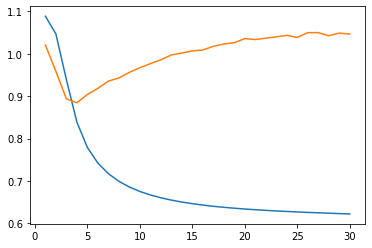

In [14]:
plt.plot([i for i in range(1, EPOCHS+1)], history.history['loss'])
plt.plot([i for i in range(1, EPOCHS+1)], history.history['val_loss'])

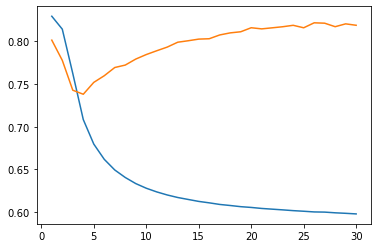

In [15]:
plt.plot([i for i in range(1, EPOCHS+1)], history.history['MAE'])
plt.plot([i for i in range(1, EPOCHS+1)], history.history['val_MAE'])

### 15 epochs seems to be ideal

In [16]:
model_final = Model(inputs=[inputs1, inputs2], outputs=y)
model_final.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='MSE',
    metrics=['MAE']
)

In [17]:
history = model_final.fit(x=[trainf_X.userId, trainf_X.movieId], y=trainf_y, epochs=15, batch_size=BATCH_SIZE)

Epoch 1/15
316/316 [==============================] - 2s 8ms/step - loss: 0.6860 - MAE: 0.6313
Epoch 2/15
316/316 [==============================] - 2s 7ms/step - loss: 0.6595 - MAE: 0.6186
Epoch 3/15
316/316 [==============================] - 2s 7ms/step - loss: 0.6412 - MAE: 0.6092
Epoch 4/15
316/316 [==============================] - 2s 7ms/step - loss: 0.6273 - MAE: 0.6010
Epoch 5/15
316/316 [==============================] - 2s 7ms/step - loss: 0.6152 - MAE: 0.5950
Epoch 6/15
316/316 [==============================] - 2s 8ms/step - loss: 0.6044 - MAE: 0.5891
Epoch 7/15
316/316 [==============================] - 2s 7ms/step - loss: 0.5943 - MAE: 0.5834
Epoch 8/15
316/316 [==============================] - 2s 7ms/step - loss: 0.5846 - MAE: 0.5779
Epoch 9/15
316/316 [==============================] - 2s 7ms/step - loss: 0.5759 - MAE: 0.5741
Epoch 10/15
316/316 [==============================] - 2s 8ms/step - loss: 0.5663 - MAE: 0.5687
Epoch 11/15
316/316 [============================

In [18]:
y_pred = model_final.predict([test_X.userId, test_X.movieId])

In [19]:
y_pred = y_pred.reshape(len(y_pred),)

In [20]:
mean_absolute_error(test_y, y_pred)

0.8123612030177512

### We can also treat the problem as classification!

In [21]:
N_TEST = round(len(df) * .2)   # 20% for test
trainf, test = df.iloc[N_TEST:, :], df.iloc[:N_TEST, :]
le = LabelEncoder()
trainf_X, trainf_y = trainf.iloc[:,:-1], trainf.iloc[:,-1]
trainf_y = le.fit_transform(trainf_y)
test_X, test_y = test.iloc[:,:-1], test.iloc[:,-1]
test_y = le.transform(test_y)

In [23]:
inputs1 = Input(shape=(1,), name='userId') # userId
inputs2 = Input(shape=(1,), name='movieId') # movieId

embedding1 = Embedding(df.userId.max()+1, EMBEDDING_SIZE, input_length=1, name='userId_Embedding')(inputs1)
embedding2 = Embedding(df.movieId.max()+1, EMBEDDING_SIZE, input_length=1, name='movieId_Embedding')(inputs2)

c = Concatenate()([embedding1, embedding2])
x = Dense(32, activation='relu', name='relu1')(c)
x = Dense(16, activation='relu', name='relu2')(x)
y = Dense(10, activation='softmax' ,name='output')(x)

model = Model(inputs=[inputs1, inputs2], outputs=y, name='DL_Recommender')
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['acc']
    )

model.summary()

Model: "DL_Recommender"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
userId (InputLayer)             [(None, 1)]          0                                            
__________________________________________________________________________________________________
movieId (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
userId_Embedding (Embedding)    (None, 1, 5)         3055        userId[0][0]                     
__________________________________________________________________________________________________
movieId_Embedding (Embedding)   (None, 1, 5)         968050      movieId[0][0]                    
_____________________________________________________________________________________

In [24]:
history = model.fit(x=[trainf_X.userId, trainf_X.movieId], y=trainf_y, epochs=30, validation_split=.1, batch_size=BATCH_SIZE)

Epoch 1/30
284/284 [==============================] - 3s 9ms/step - loss: 2.2559 - acc: 0.1989 - val_loss: 2.1936 - val_acc: 0.2008
Epoch 2/30
284/284 [==============================] - 2s 7ms/step - loss: 2.1199 - acc: 0.1962 - val_loss: 2.0479 - val_acc: 0.2008
Epoch 3/30
284/284 [==============================] - 2s 7ms/step - loss: 2.0157 - acc: 0.2378 - val_loss: 1.9868 - val_acc: 0.2681
Epoch 4/30
284/284 [==============================] - 2s 7ms/step - loss: 1.9738 - acc: 0.2670 - val_loss: 1.9622 - val_acc: 0.2681
Epoch 5/30
284/284 [==============================] - 2s 7ms/step - loss: 1.9423 - acc: 0.2670 - val_loss: 1.9391 - val_acc: 0.2681
Epoch 6/30
284/284 [==============================] - 2s 8ms/step - loss: 1.9084 - acc: 0.2670 - val_loss: 1.9164 - val_acc: 0.2681
Epoch 7/30
284/284 [==============================] - 3s 9ms/step - loss: 1.8747 - acc: 0.2684 - val_loss: 1.8962 - val_acc: 0.2716
Epoch 8/30
284/284 [==============================] - 2s 9ms/step - loss: 1.

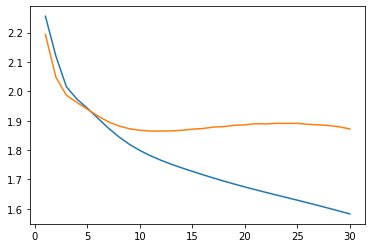

In [25]:
plt.plot([i for i in range(1, EPOCHS+1)], history.history['loss'])
plt.plot([i for i in range(1, EPOCHS+1)], history.history['val_loss'])

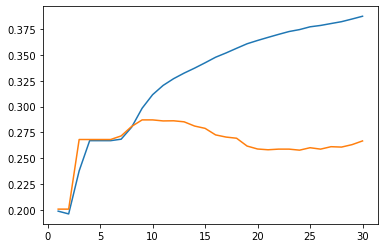

In [26]:
plt.plot([i for i in range(1, EPOCHS+1)], history.history['acc'])
plt.plot([i for i in range(1, EPOCHS+1)], history.history['val_acc'])

In [27]:
model_final = Model(inputs=[inputs1, inputs2], outputs=y)
model_final.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
     loss='sparse_categorical_crossentropy',
    metrics=['acc', 'MAE']
)

In [28]:
history = model_final.fit(x=[trainf_X.userId, trainf_X.movieId], y=trainf_y, epochs=4, batch_size=BATCH_SIZE)

Epoch 1/4
316/316 [==============================] - 3s 10ms/step - loss: 1.5996 - acc: 0.3789 - MAE: 5.9196
Epoch 2/4
316/316 [==============================] - 3s 9ms/step - loss: 1.5851 - acc: 0.3832 - MAE: 5.9195
Epoch 3/4
316/316 [==============================] - 3s 8ms/step - loss: 1.5728 - acc: 0.3878 - MAE: 5.9193
Epoch 4/4
316/316 [==============================] - 3s 8ms/step - loss: 1.5620 - acc: 0.3904 - MAE: 5.9196


In [29]:
from sklearn.metrics import accuracy_score
y_pred = np.argmax(model_final.predict([test_X.userId, test_X.movieId]), axis=-1)
y_pred = y_pred.reshape(len(y_pred),)

accuracy_score(test_y, y_pred), mean_absolute_error(le.inverse_transform(test_y), le.inverse_transform(y_pred))

(0.27485496107502355, 0.811102295829821)

In [31]:
np.argmax(model_final.predict([test_X.userId, test_X.movieId]), axis=-1)

array([[5],
       [6],
       [5],
       ...,
       [8],
       [9],
       [7]], dtype=int64)

In [32]:
y_pred, test_y

(array([5, 6, 5, ..., 8, 9, 7], dtype=int64),
 array([5, 5, 4, ..., 7, 9, 8], dtype=int64))